In [32]:
# %pip install opendatasets
# %pip install prophet

# import opendatasets as od
import pandas as pd
import numpy as np

# od.download('https://www.kaggle.com/datasets/arjuntejaswi/plant-village')

In [33]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt

In [34]:
import tensorboard

In [35]:
directory = 'plant-village'

# Generates a tf.data.Dataset from image files in a directory.
df = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 2152 files belonging to 3 classes.


In [36]:
class_names = df.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


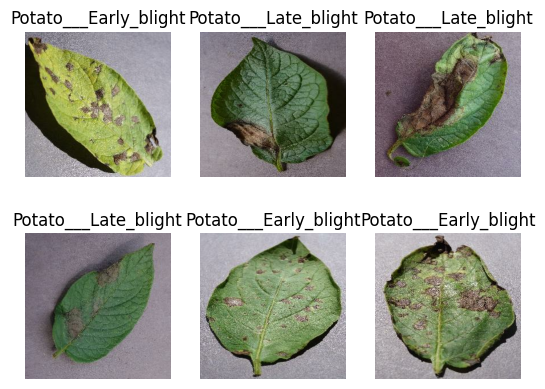

In [37]:
for images, labels in df.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(df.class_names[labels[i]])
        plt.axis("off")

In [38]:
# tf.take(10) will take 10 image sets from the dataset
# tf.skip(10) will skip 10 image sets from the dataset
# doen't need to shuffle the dataset as it is already shuffled

train_ds = df.take(54)
test_ds = df.skip(54)

val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

In [39]:
print(len(df), len(train_ds), len(val_ds), len(test_ds))

68 54 6 8


In [40]:
# cache the dataset in the memory to improve performance
# prefetch the dataset to improve performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
# resising images as new images may be of different size
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255)
])

In [42]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(.1),
#     layers.RandomContrast(0.2),
])

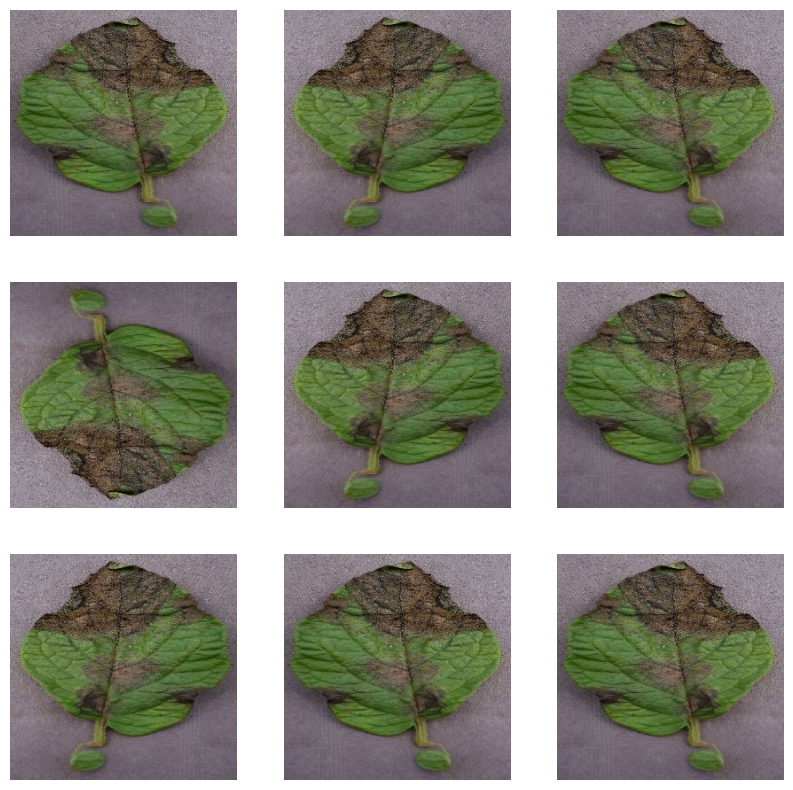

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [44]:
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, 3 , activation='relu', padding='same', input_shape=(256, 256, 3)),
    layers.MaxPool2D(2),
    layers.Conv2D(64, 3 , activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(64, 3 , activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(64, 3 , activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(64, 3 , activation='relu', padding='same'),
    layers.MaxPool2D(2),
    # layers.Conv2D(64, 3 , activation='relu', padding='same'),
    # layers.MaxPool2D(2),
    
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=(32, 256, 256, 3))

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 128, 128, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 64, 64, 64)         0         
 2D)                                                  

In [46]:
model.compile(
    optimizer='adam',
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, 
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
54/54 [==============================] - 10s 162ms/step - loss: 0.7802 - accuracy: 0.6053 - val_loss: 0.4490 - val_accuracy: 0.8646
Epoch 2/20
54/54 [==============================] - 7s 127ms/step - loss: 0.4173 - accuracy: 0.8409 - val_loss: 0.3477 - val_accuracy: 0.8802
Epoch 3/20
54/54 [==============================] - 7s 127ms/step - loss: 0.2574 - accuracy: 0.9045 - val_loss: 0.1537 - val_accuracy: 0.9479
Epoch 4/20
54/54 [==============================] - 7s 126ms/step - loss: 0.1686 - accuracy: 0.9387 - val_loss: 0.1265 - val_accuracy: 0.9635
Epoch 5/20
54/54 [==============================] - 7s 126ms/step - loss: 0.1651 - accuracy: 0.9398 - val_loss: 0.1618 - val_accuracy: 0.9479
Epoch 6/20
54/54 [==============================] - 7s 127ms/step - loss: 0.1369 - accuracy: 0.9456 - val_loss: 0.2544 - val_accuracy: 0.9115
Epoch 7/20
54/54 [==============================] - 7s 127ms/step - loss: 0.1126 - accuracy: 0.9583 - val_loss: 0.3619 - val_accuracy: 0.9062
Epoch

In [48]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 32ms/step - loss: 0.1749 - accuracy: 0.9526


[0.174865260720253, 0.9525862336158752]

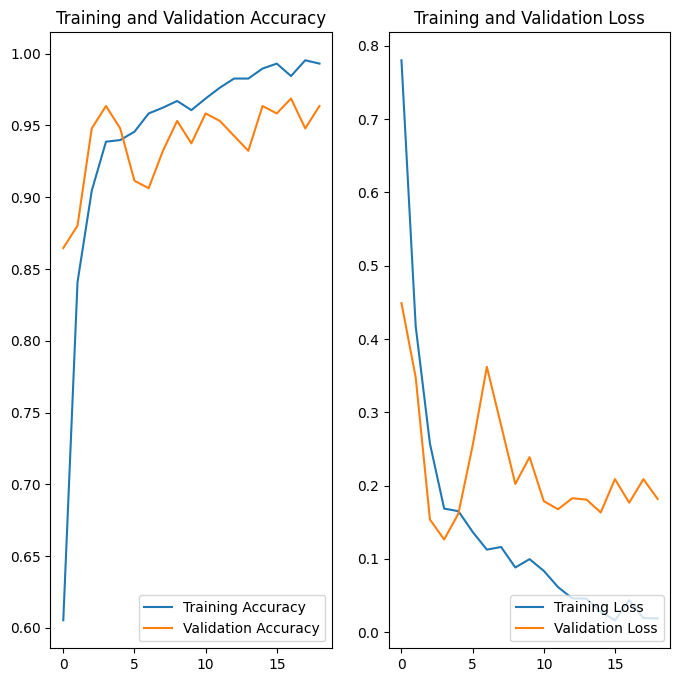

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.epoch)), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.epoch)), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(history.epoch)), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.epoch)), history.history['val_loss'], label='Validation Loss')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Loss')

plt.show()

In [50]:
class_names = df.class_names
 

def predict(model, img):

    # Returns a tensor with a length 1 axis inserted at index axis.
    # (256, 256, 3) to (1, 256, 256, 3)
    img_array = tf.expand_dims(img,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


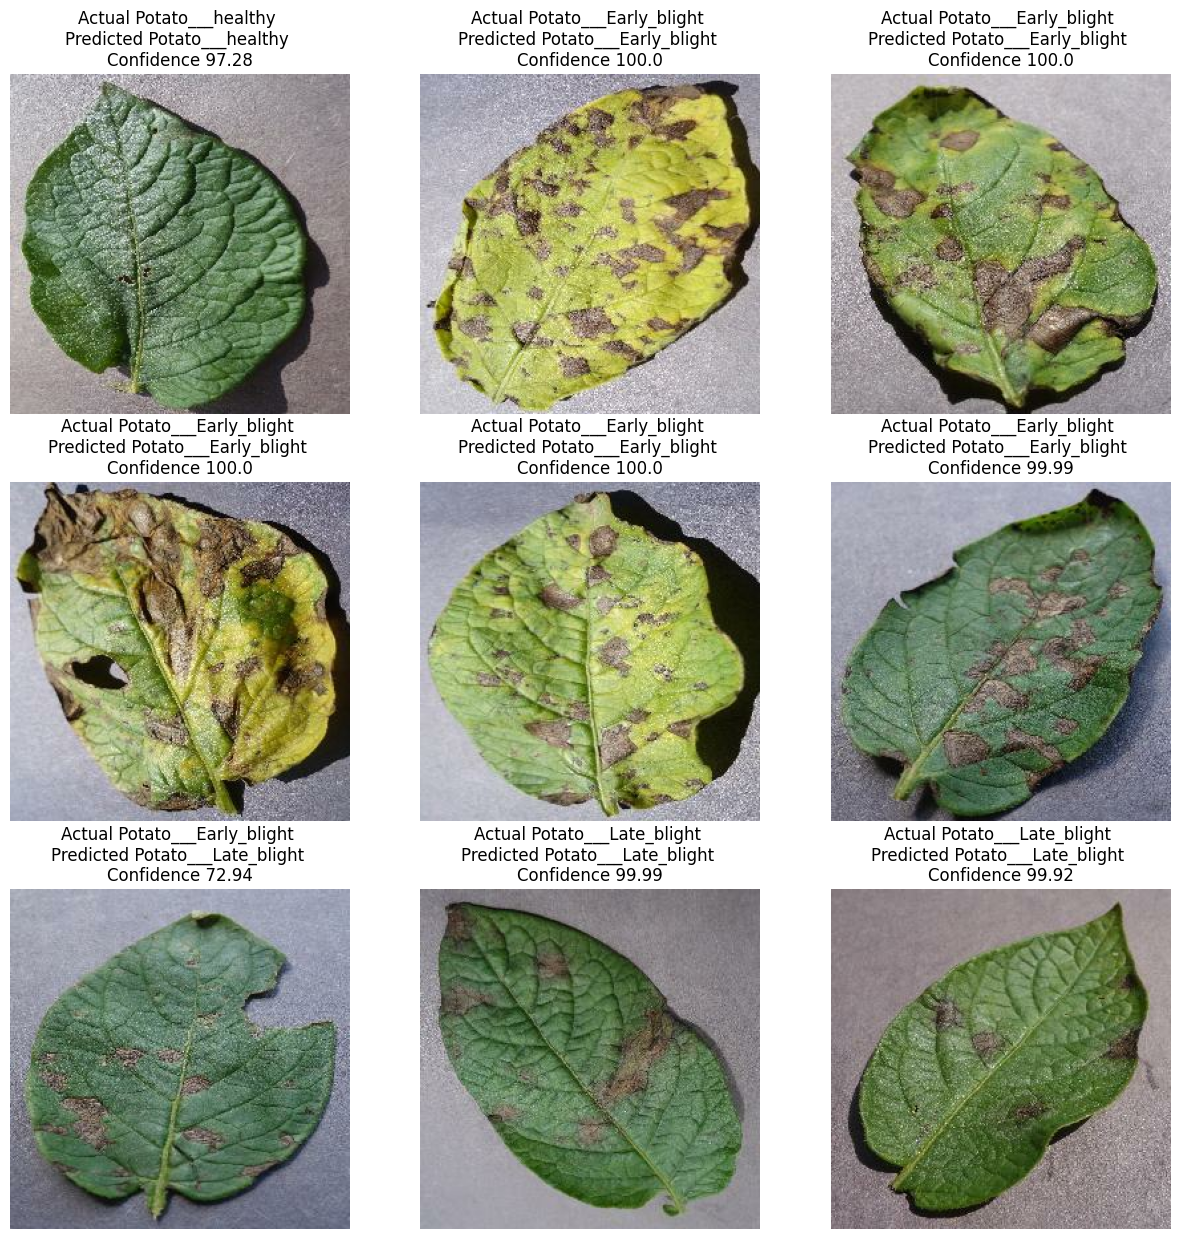

In [51]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual {actual_class} \nPredicted {predicted_class} \nConfidence {confidence}')
        plt.axis('off')

In [52]:
model_version = 1
model.save(f'/models/{model_version}')

INFO:tensorflow:Assets written to: /models/1\assets


INFO:tensorflow:Assets written to: /models/1\assets


In [53]:
model = tf.keras.models.load_model('/models/1')